___

# <span style="color:#00369c;">Projet de Webmining et Traitement du langage naturel</span>

<table style="width:100%; text-align:center;">
  <tr>
    <td>
      <strong style="font-size: 25px;">Davyd Bayard</strong><br>
      <a href="https://www.linkedin.com/in/davyd-bayard/">
        <img src="https://media.licdn.com/dms/image/D4E03AQGVOp1OztlUwA/profile-displayphoto-shrink_800_800/0/1677345039076?e=1715212800&v=beta&t=PKTHEjBxLRsRygBnFFj4otK_PjgbHYwXSM6qa84s9kc" alt="Davyd Bayard" width="200"/>
      </a>
    </td>
    <td>
      <strong style="font-size: 25px;">Guillaume Poirier</strong><br>
      <a href="https://www.linkedin.com/in/guillaume-poirier-41231713a/">
        <img src="https://media.licdn.com/dms/image/D4E03AQEyJMrFoKxchQ/profile-displayphoto-shrink_800_800/0/1664483713894?e=1715212800&v=beta&t=s0-iRjARTl6NGA7rAlW0hp1EQCPGLjbVmX223HIhVPI" alt="Guillaume Poirier" width="200"/>
      </a>
    </td>
  </tr>
</table>


___


<img src="https://img-0.journaldunet.com/ncnLdbj2tdRoYqV-c_Q6_b9SPA0=/1500x/smart/36216b4b04c2491090e62bc6cf1c8db5/ccmcms-jdn/34555171.jpg"/>

# <span style="color:#00369c;">Objectif</span>

Dans cette seconde partie du TP, nous abordons la tâche de détection des entités nommées en tant que problème d'étiquetage. L'objectif est de développer le système le plus performant possible en utilisant les connaissances acquises en cours et les compétences en implémentation de modèles neuronaux sous **tf.keras**, telles que vues dans la première partie. Nous travaillerons avec les données de la compétition CONLL 2003, qui comprennent trois ensembles de données étiquetées selon le modèle BIO, pour l'apprentissage, la validation et les tests.

# <span style="color:#00369c;">Import et Observation des données</span>

In [1]:
#On commence par extraire les jeux de données
# Il existe un lien permettant de télégarger les données (Hugging Face)
#Ce zip contient le train, validation et test dataset et un fichier de metadata

import urllib.request
import zipfile
import os

#URL de Hugging Face
url = "https://data.deepai.org/conll2003.zip"

#Nom du fichier après le téléchargement
zip_filename = "conll2003.zip"

#On utilise urllib pour télécharger l'archive
urllib.request.urlretrieve(url, zip_filename)

#On définit le nom du répertoire qui contiendra les différents datasets
extract_dir = "conll2003_data"

#On extrait les fichiers avec le package zipfile
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

#Puis on supprime l'archive zip qui ne sert plus à rien
os.remove(zip_filename)

print("Extraction terminée.")

Extraction terminée.


In [2]:
#A présent, on va observer la structure des données, ici on a choisi le fichier train
train_file = "conll2003_data/train.txt"

#On lit les 5 premières lignes du fichier avec un simple with open() et méthode readline()
with open(train_file, 'r', encoding='utf-8') as file:
    for i in range(50):
        line = file.readline()
        print(line.strip())

-DOCSTART- -X- -X- O

EU NNP B-NP B-ORG
rejects VBZ B-VP O
German JJ B-NP B-MISC
call NN I-NP O
to TO B-VP O
boycott VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
. . O O

Peter NNP B-NP B-PER
Blackburn NNP I-NP I-PER

BRUSSELS NNP B-NP B-LOC
1996-08-22 CD I-NP O

The DT B-NP O
European NNP I-NP B-ORG
Commission NNP I-NP I-ORG
said VBD B-VP O
on IN B-PP O
Thursday NNP B-NP O
it PRP B-NP O
disagreed VBD B-VP O
with IN B-PP O
German JJ B-NP B-MISC
advice NN I-NP O
to TO B-PP O
consumers NNS B-NP O
to TO B-VP O
shun VB I-VP O
British JJ B-NP B-MISC
lamb NN I-NP O
until IN B-SBAR O
scientists NNS B-NP O
determine VBP B-VP O
whether IN B-SBAR O
mad JJ B-NP O
cow NN I-NP O
disease NN I-NP O
can MD B-VP O
be VB I-VP O
transmitted VBN I-VP O
to TO B-PP O
sheep NN B-NP O
. . O O

Germany NNP B-NP B-LOC


De ça on a plusieurs remarques :
- Les champs sont séparés par des espaces.
- Chaque ligne est séparée par un retour à la ligne (\n).
- Une phrase se termine lorsqu'il n'y a plus de mots (il y a un mot vide entre chaque phrase).
- Le header est mal formulé. Nous avons identifié les champs suivants en nous basant sur la documentation de la base de données disponible sur [HuggingFace](https://huggingface.co/datasets/conll2003) :
    - Token : représente chaque token dans le texte
    - Pos : indique la partie de discours (Part-Of-Speech) associée à chaque token
    - Chunk : représente le chunking, qui est une tâche d'analyse syntaxique consistant à diviser une phrase en morceaux de mots plus petits (chunks).
    - NE : indique l'entité nommée (Named Entity) associée à chaque token

# <span style="color:#00369c;">Structuration de la donnée</span>

Cette partie est consacré à la construction d'une fonction permettant de lire un fichier et de stocker en mémoire les tokens et les différentes étiquettes. Ici a choisi un format pandas pour plus de simplicité.

In [3]:
import pandas as pd

def structurer_donnee(filename):
    """
    Fonction pour structurer les données à partir d'un fichier.

    Parameters:
    filename (str): Chemin du fichier contenant les données.

    Returns:
    pandas.DataFrame: DataFrame contenant les données structurées.

    Remarques:
    - Les champs sont séparés par des espaces.
    - Chaque ligne représente un mot avec ses étiquettes (POS, CHUNK, NE).
    - Une phrase se termine lorsqu'un mot est un élément vide.
    """

    df = pd.read_csv(filename,
                    sep = ' ', header = None, keep_default_na = False,
                    names = ['TOKEN', 'POS', 'CHUNK', 'NE'],
                    quoting = 3, skip_blank_lines = False)

    #On mets un identifiant sur le numéro de la phrase pour chaque mot
    #Une phrase se termine dès lors que mot est un élément vide
    df['SENTENCE'] = (df.TOKEN == '').cumsum()

    #Ici la première valeur est vide donc on l'enlève
    df = df.drop(df.index[0]).reset_index(drop=True)

    # à titre indicatif on retire les espaces superflus sur le mot
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

    # Suppression des lignes contenant des mots vides
    return df[df.TOKEN != '']


train_df = structurer_donnee('conll2003_data/train.txt')
valid_df = structurer_donnee('conll2003_data/valid.txt')
test_df = structurer_donnee('conll2003_data/test.txt')

train_df.head()

/tmp/ipykernel_13893/1467032446.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
/tmp/ipykernel_13893/1467032446.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
/tmp/ipykernel_13893/1467032446.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


,TOKEN,POS,CHUNK,NE,SENTENCE
1,EU,NNP,B-NP,B-ORG,1
2,rejects,VBZ,B-VP,O,1
3,German,JJ,B-NP,B-MISC,1
4,call,NN,I-NP,O,1
5,to,TO,B-VP,O,1


In [4]:
#Quelques analyses
train_df.POS.value_counts()

POS
NNP       34392
NN        23899
CD        19704
IN        19064
DT        13453
JJ        11831
NNS        9903
VBD        8293
.          7389
,          7291
VB         4252
VBN        4105
RB         3975
CC         3653
TO         3469
PRP        3163
)          2866
(          2866
VBG        2585
VBZ        2426
:          2386
"          2178
POS        1553
PRP$       1520
VBP        1436
MD         1199
-X-         945
NNPS        684
WP          528
RP          528
WDT         506
SYM         439
$           427
WRB         384
JJR         382
JJS         254
FW          166
RBR         163
EX          136
RBS          35
''           35
PDT          33
UH           30
WP$          23
LS           13
NN|SYM        4
Name: count, dtype: int64

In [5]:
train_df.CHUNK.value_counts()

I-NP       66645
B-NP       57387
O          27646
B-PP       18843
B-VP       18047
I-VP        8818
B-ADVP      2637
B-SBAR      1269
B-ADJP      1165
-X-          945
B-PRT        527
I-ADJP       211
I-ADVP       138
I-PP         103
B-INTJ        59
I-CONJP       39
B-LST         32
B-CONJP       31
I-SBAR        19
I-LST          4
I-INTJ         1
Name: CHUNK, dtype: int64

In [6]:
train_df.NE.value_counts()

O         170523
B-LOC       7140
B-PER       6600
B-ORG       6321
I-PER       4528
I-ORG       3704
B-MISC      3438
I-LOC       1157
I-MISC      1155
Name: NE, dtype: int64

In [5]:
#Nb d'étiquettes
ntags = len(train_df['NE'].unique())
print("Nombre d'étiquettes : ", ntags)

#Nb tokens
ntokens = len(train_df['TOKEN'].unique())
print("Nombre de token : ", ntokens)

#Longueur max d'une séquence
# Calculer maxlen en prenant le maximum de la longueur des phrases dans les DataFrames train_df, valid_df et test_df
maxlen_train = train_df.groupby('SENTENCE').size().max()
maxlen_valid = valid_df.groupby('SENTENCE').size().max()
maxlen_test = test_df.groupby('SENTENCE').size().max()

maxlen = max(maxlen_train, maxlen_valid, maxlen_test)

print("Longueur maximal d'une phrase : ", maxlen, " tokens")

#Nombre de phrase au total
sentence_max = len(train_df.groupby('SENTENCE'))
print("Nombre de phrase au total possible : ", sentence_max)

Nombre d'étiquettes :  9
Nombre de token :  23624
Longueur maximal d'une phrase :  124  tokens
Nombre de phrase au total possible :  14986


# <span style="color:#00369c;">Préparation de données</span>

Cette section vise à préparer les données pour être utilisées dans des algorithmes de type réseau récurrent. Ces algorithmes traitent des séquences de tokens. Pour chaque token dans une séquence, les étiquettes associées sont représentées sous forme de vecteurs one hot. En d'autres termes, pour une séquence de longueur L, les étiquettes sont représentées sous forme d'une matrice L × N, où N est le nombre possible d'étiquettes.

In [6]:
import numpy as np
from keras.utils import to_categorical

def create_sequences(data, maxlen, label_set):
    """
    Crée des séquences de tokens et encode les étiquettes en vecteurs one-hot.

    Args:
        data (DataFrame): DataFrame contenant les données à traiter.
        maxlen (int): Longueur maximale des séquences de tokens.
        label_set (array-like): Ensemble des étiquettes possibles.

    Returns:
        tuple: Un tuple contenant les séquences de tokens et les étiquettes encodées en vecteurs one-hot.

    """
    #listes pour stocker les séquences de tokens et les étiquettes
    sequences = []
    labels = []

    #dictionnaire pour mapper les étiquettes aux entiers
    label_to_int = {label: i for i, label in enumerate(label_set)}

    #Parcourir chaque groupe de phrases dans les données, groupées par identifiant de phrase
    for sentence_id, sentence_group in data.groupby('SENTENCE'):
        #listes pour stocker les tokens et les étiquettes de la phrase
        sentence_tokens = []
        sentence_labels = []

        #Parcourir chaque ligne dans le groupe de phrases
        for _, row in sentence_group.iterrows():
            #On ajoute le token et de l'étiquette à leurs listes respectives
            sentence_tokens.append(row['TOKEN'])
            sentence_labels.append(row['NE'])

        #On effectue un rembourrage pour remplir la séquence
        padded_tokens = sentence_tokens[:maxlen] + [''] * (maxlen - len(sentence_tokens))

        #On encode les étiquettes en utilisant le dictionnaire de mapping
        #On ajoute 0 pour le padding si la longueur est inférieure à maxlen
        encoded_labels = [label_to_int[label] for label in sentence_labels[:maxlen]] + [0] * (maxlen - len(sentence_labels))

        #On ajoute au listes les séquences de tokens et les étiquettes encodées
        sequences.append(padded_tokens)
        labels.append(encoded_labels)

    #liste en tableaux numpy
    sequences = np.array(sequences)
    labels = np.array(labels)

    #On encode les labels en vecteurs one-hot (sujet)  avec to_categorical() de Keras
    labels = to_categorical(labels, num_classes=len(label_set))

    return sequences, labels


#Application de la fonction sur les 3 jeux de données
train_sequences, train_labels = create_sequences(train_df, maxlen, train_df['NE'].unique())
valid_sequences, valid_labels = create_sequences(valid_df, maxlen, valid_df['NE'].unique())
test_sequences, test_labels = create_sequences(test_df, maxlen, test_df['NE'].unique())

#On vérifie les dimensions
print("Dimension des tokens:", train_sequences.shape)
print("Dimension des labels:", train_labels.shape)


2024-03-11 00:54:01.741181: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-11 00:54:01.743484: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-11 00:54:01.774456: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-11 00:54:02.416099: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Dimension des tokens: (14986, 124)
Dimension des labels: (14986, 124, 9)


In [9]:
#Aperçu de la liste des  séquences de labels
train_labels[:2]

array([[[1., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]], dtype=float32)

In [10]:
#Aperçu de la séquence destokens
train_sequences

array([['EU', 'rejects', 'German', ..., '', '', ''],
       ['Peter', 'Blackburn', '', ..., '', '', ''],
       ['BRUSSELS', '1996-08-22', '', ..., '', '', ''],
       ...,
       ['Plymouth', '2', 'Preston', ..., '', '', ''],
       ['Division', 'three', '', ..., '', '', ''],
       ['Swansea', '1', 'Lincoln', ..., '', '', '']], dtype='<U61')

In [7]:
#On créer un dictionnaire pour mapper les tokens à des entiers
token_to_int = {token: i + 1 for i, token in enumerate(sorted(set(train_df['TOKEN'])))}

#Pour chaque séquences (train, test, validation) on convertie les séquences  de token en séquence d'entier
train_sequences_int = np.array([[token_to_int.get(token, 0) for token in sentence] for sentence in train_sequences])
valid_sequences_int = np.array([[token_to_int.get(token, 0) for token in sentence] for sentence in valid_sequences])
test_sequences_int = np.array([[token_to_int.get(token, 0) for token in sentence] for sentence in test_sequences])

#Aperçu des 5 premières séquences
print(train_sequences_int[:5])

[[ 6420 20821  7229 14822 22700 14673  5084 18390   125     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0]
 [10721  4911     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0    

# <span style="color:#00369c;">Construction du modèle et évaluation</span>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Embedding, LSTM, TimeDistributed, Dense, Activation
from tensorflow.keras.optimizers import Adam

#On définit les dimensions des embeddings et des vecteurs LSTM (arbitraire)
embed_dim = 50
lstm_dim = 100

#On créé un dictionnaire pour mapper les étiquettes à des entiers
label_to_int = {label: i for i, label in enumerate(sorted(set(train_df['NE'])))}

#Modèle NER1 (sujet)
ner1 = Sequential()
ner1.add(InputLayer(input_shape=(maxlen, )))
ner1.add(Embedding(input_dim=len(token_to_int) + 1, output_dim=embed_dim, mask_zero=True))
ner1.add(LSTM(lstm_dim, return_sequences=True))
ner1.add(TimeDistributed(Dense(len(label_to_int))))
ner1.add(Activation('softmax'))

#Compilation
ner1.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

#Résumé du modèle
ner1.summary()

#Entrainement du modèle
history = ner1.fit(train_sequences_int, train_labels, validation_data=(valid_sequences_int, valid_labels), epochs=10, batch_size=32)

#Evaluation sur le jeu de validation
loss, accuracy = ner1.evaluate(valid_sequences_int, valid_labels)
print("Loss sur l'ensemble de validation:", loss)
print("Précision sur l'ensemble de validation:", accuracy)


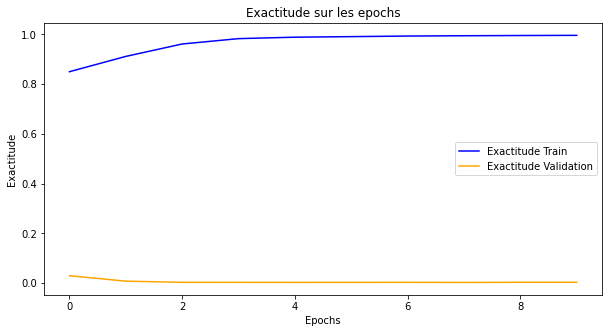

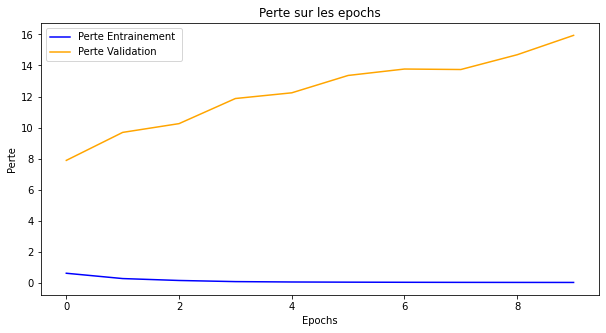

In [13]:
#Courbe de l'évolution de la précision et de la perte en fonction des epochs

import matplotlib.pyplot as plt
#Récupérer les informations de l'entrainement
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

#Exactitude
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Exactitude Train', color='blue')
plt.plot(val_accuracy, label='Exactitude Validation', color='orange')
plt.title('Exactitude sur les epochs')
plt.xlabel('Epochs')
plt.ylabel('Exactitude')
plt.legend()
plt.show()

#Perte
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Perte Entrainement ', color='blue')
plt.plot(val_loss, label='Perte Validation', color='orange')
plt.title('Perte sur les epochs')
plt.xlabel('Epochs')
plt.ylabel('Perte')
plt.legend()
plt.show()

# <span style="color:#00369c;">Jeu de donnée test</span>

In [14]:
#On calcule les prédictions sur la séquence du jeu de données test
predictions = ner1.predict(test_sequences_int)

def decode_predictions(predictions, sequences):
    """
    Décode les prédictions du modèle en étiquettes prédites.

    Args:
        predictions (list): Liste de listes représentant les prédictions du modèle pour chaque token dans chaque séquence.
        sequences (list): Liste de listes représentant les séquences de tokens.

    Returns:
        list: Liste de listes contenant les étiquettes prédites pour chaque token dans chaque séquence.

    La fonction parcourt les prédictions du modèle et les séquences de tokens, elle décode chaque prédiction en étiquette prédite en utilisant l'indice de la classe avec la probabilité la plus élevée, puis les ajoute à une liste de listes pour représenter les étiquettes prédites pour chaque token dans chaque séquence.

    Les tokens de rembourrage (chaînes vides) sont ignorés et ne sont pas inclus dans les étiquettes prédites.

    Exemple d'utilisation:
        predictions = ner_model.predict(test_sequences_int)
        predicted_labels = decode_predictions(predictions, test_sequences)
    """
    # Définir un dictionnaire pour convertir les indices de classe en étiquettes prédites
    int_to_label = {0: 'O', 1: 'B-LOC', 2: 'B-PER', 3: 'I-PER', 4: 'I-LOC', 5: 'B-MISC', 6: 'I-MISC', 7: 'B-ORG', 8: 'I-ORG'}

    decoded_labels = []
    for i, sequence in enumerate(predictions):
        decoded_sequence = []
        for j, token_probs in enumerate(sequence):
            # Vérifier si le token est un token de rembourrage
            if sequences[i][j] != '&RBRRG':
                # Sélectionner l'indice de la classe avec la probabilité la plus élevée
                predicted_label_index = np.argmax(token_probs)

                # Convertir l'indice de la classe en étiquette prédite en utilisant le dictionnaire inverse
                predicted_label = int_to_label[predicted_label_index]
            else:
                # Ignorer les tokens de rembourrage
                predicted_label = '&RBRRG'

            decoded_sequence.append(predicted_label)
        decoded_labels.append(decoded_sequence)
    return decoded_labels


#Utiliser la fonction pour décoder les prédictions
predicted_labels = decode_predictions(predictions, test_sequences)

#Aperçu des étiquettes prédites pour les 5 premières séquences de test
for i in range(5):
    print("Séquence {}:".format(i+1))

    #Pour l'esthétique
    #On filtre les tokens et les étiquettes prédites contenant des chaînes vides
    filtered_tokens = [token for token in test_sequences[i] if token != '']
    filtered_predicted_labels = [label for label in predicted_labels[i] if label != '']

    print("Tokens:", filtered_tokens)
    print("Étiquettes prédites:", filtered_predicted_labels)

    print()

116/116 [==============================] - 9s 61ms/step
Séquence 1:
Tokens: ['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'CHINA', 'IN', 'SURPRISE', 'DEFEAT', '.']
Étiquettes prédites: ['B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'O', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', '

# <span style="color:#00369c;">Pourquoi ne pas utiliser evaluate directement ?</span>

La fonction evaluate est généralement utilisée pour évaluer les performances d'un modèle sur un ensemble de données pour lequel les labels réels sont connus. Cependant, dans le cas des **modèles de séquence** pour la détection d'entités nommées (NER), les prédictions du modèle et les véritables étiquettes doivent être comparées au niveau **des séquences** plutôt qu'au niveau **des points de données**.

La fonction *evaluate* calcule les métriques de performance (telles que la perte et la précision) sur un ensemble de données, mais elle ne prend pas en compte la **structure des séquences** dans ces données. Elle traite chaque point de données **individuellement**, ce qui n'est pas approprié pour les tâches de **séquence** comme NER où la structure de la séquence est importante.

Il est évident qu'il y a un déséquilibre dans les catégories à prédire, comme on peut le voir avec la commande value_count qui révèle qu'il y a beaucoup plus d'occurrences de la catégorie 'O' que des autres catégories. Pour rappel, 'O' désigne la catégorie des mots qui ne sont pas pertinents pour la tâche spécifique (tels que les déterminants, les liaisons, etc.) ainsi que les tokens de remplissage. Par conséquent, l'utilisation de la fonction evaluate serait inappropriée ici car elle ne prend pas en compte le déséquilibre des classes lors de l'évaluation du modèle.

Une possibilité est d'utiliser la fonction ***compute_class_weight*** de ***sklearn*** qui permet de balancer les classes et, comme indiqué dans le sujet, de creer ces propres fonctions d'évaluations. On peut aussi utiliser ***precision_recall_fscore_support*** de ***sklearn*** comme indiqué ci après.

# <span style="color:#00369c;">Fonction pour mesurer les scores</span>

In [11]:
from sklearn.metrics import precision_recall_fscore_support

def calculate_scores(true_labels, predicted_labels):
    """
    Calcule les scores de rappel, précision et F1-score pour chaque étiquette spécifiée et pour l'ensemble des étiquettes.

    Args:
        true_labels (list): Liste des vrais labels.
        predicted_labels (list): Liste des labels prédits.

    Returns:
        dict: Un dictionnaire contenant les scores de rappel, précision et F1-score pour chaque étiquette et pour l'ensemble des étiquettes.

    La fonction calcule les scores de rappel, précision et F1-score pour chaque étiquette spécifiée ('B-LOC', 'I-LOC', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-MISC', 'I-MISC')
    ainsi que pour l'ensemble de ces étiquettes ('Global'). Les scores sont calculés en comparant les étiquettes véritables avec les étiquettes prédites.
    Les étiquettes sont considérées de manière binaire ('1' pour présence de l'étiquette et '0' sinon).

    """
    #Liste des 9 entités possibles
    labels = ['B-LOC', 'I-LOC', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-MISC', 'I-MISC']

    #dictionnaire pour stocker les scores
    scores = {}

    #calculer les scores pour chaque label spécifié
    for label in labels:
        #On récupère les indices des étiquettes vraies et prédites correspondant à l'étiquette actuelle
        indices_true = [i for i, x in enumerate(true_labels) if x == label]
        indices_pred = [i for i, x in enumerate(predicted_labels) if x == label]

        #On convertie les étiquettes en format binaire (1 si l'indice est présent, 0 sinon)
        true_labels_binary = [1 if i in indices_true else 0 for i in range(len(true_labels))]
        predicted_labels_binary = [1 if i in indices_pred else 0 for i in range(len(predicted_labels))]

        #On calcule les scores de précision, rappel et F1-score pour l'étiquette actuelle
        precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_binary, predicted_labels_binary, average='binary', zero_division=0)

        #On stocke les scores dans le dictionnaire
        scores[label] = {'Recall': recall, 'Precision': precision, 'F1-score': f1_score}

    #On calcule les scores globaux pour l'ensemble des étiquettes
    true_labels_binary_global = ['B-' in x or 'I-' in x for x in true_labels]
    predicted_labels_binary_global = ['B-' in x or 'I-' in x for x in predicted_labels]

    precision_global, recall_global, f1_score_global, _ = precision_recall_fscore_support(true_labels_binary_global, predicted_labels_binary_global, average='binary', zero_division=0)

    #On stocke les scores globaux dans le dictionnaire
    scores['Global'] = {'Recall': recall_global, 'Precision': precision_global, 'F1-score': f1_score_global}

    return scores


In [16]:
#On extrait des étiquettes vraies du DataFrame de test du début
true_labels = test_df.groupby("SENTENCE")["NE"].apply(list).tolist()

#On nettoie les étiquettes prédites en enlevant les étiquettes vides
#Il faut les même longueurs pour les étiquettes prédits et véritables
predicted_labels_cleaned = [[label for label in sequence if label != ''] for sequence in predicted_labels]

#On calcule les scores en utilisant la fonction calculate_scores définit plus haut
scores = calculate_scores(true_labels, predicted_labels_cleaned)

#On affiche les scores pour chaque étiquette et pour le score global
for label, score in scores.items():
    print(f"{label}: Recall = {score['Recall']:.2f}, Precision = {score['Precision']:.2f}, F1-score = {score['F1-score']:.2f}")

#Score global
print("Global: Recall = {:.2f}, Precision = {:.2f}, F1-score = {:.2f}".format(scores['Global']['Recall'], scores['Global']['Precision'], scores['Global']['F1-score']))


B-LOC: Recall = 0.00, Precision = 0.00, F1-score = 0.00
I-LOC: Recall = 0.00, Precision = 0.00, F1-score = 0.00
B-PER: Recall = 0.00, Precision = 0.00, F1-score = 0.00
I-PER: Recall = 0.00, Precision = 0.00, F1-score = 0.00
B-ORG: Recall = 0.00, Precision = 0.00, F1-score = 0.00
I-ORG: Recall = 0.00, Precision = 0.00, F1-score = 0.00
B-MISC: Recall = 0.00, Precision = 0.00, F1-score = 0.00
I-MISC: Recall = 0.00, Precision = 0.00, F1-score = 0.00
Global: Recall = 0.00, Precision = 0.00, F1-score = 0.00
Global: Recall = 0.00, Precision = 0.00, F1-score = 0.00


In [19]:
# Utilisation de np.unique avec return_counts=True
elements, occurrences = np.unique(predicted_labels_cleaned, return_counts=True)

# Affichage des éléments et de leurs occurrences
for elem, count in zip(elements, occurrences):
    print(elem, ":", count)

B-LOC : 394961
B-MISC : 28211
B-ORG : 3131
B-PER : 2479
I-LOC : 2212
I-MISC : 4052
I-ORG : 5731
I-PER : 4861
O : 11054


# <span style="color:#00369c;">Améliorer le modèle</span>

## Tokeniser
### Méthode 1 : utilisée jusqu'à maintenant
Dans la première façon (en suivant l'énoncé du sujet du TP), nous avons :
- créer des  séquences de tokens et encoder les étiquettes en vecteurs one-hot
- convertis les tokens en séquences d'entiers à l'aide d'un dictionnaire qui mappe chaque token à un entier unique

### Méthode 2  : utilisation d'un tokenizer pré-entrainé
Dans la 2e méthode qu'on propose est :
- utiliser un tokenizer pré-entraîné de la bibliothèque Transformers pour tokeniser les échantillons (ici on a choisi bert-base-cased comme modèle) et donc créer les séquences de sous-tokens.
- pour les étiquettes, elles sont mappées aux indices des étiquettes définis dans un schéma spécifié (valeurs possibles de NE)

### Avantages :
- <b>Représentations de mots contextualisées :</b> contrairement à la méthode one-hot, BERT produit des représentations de mots qui sont contextualisées (chaque mot est représenté de manière dynamique en fonction des mots qui l'entourent dans la phrase).
- <b>Gestion des sous-mots (subwords) : </b> BERT utilise un tokenizer qui peut diviser les tokens en sous-tokens plus petits => gestion des tokens rares ou inconnus en les décomposant en parties plus petits qui peuvent être mieux compris. Exemple : si un modèle n'a jamais vu le token "anticonstitutionnellement", il peut le diviser en sous-token plus courts comme "anti", "constitution", "elle", "ment", qui peuvent être plus facilement reconnus.  
- <b>Amélioration de la performance :</b> les deux avantages ci-dessus impliquent une performance meilleure sur une variété de tâches de traitement du langage naturel comme la détection de NE.

## Modèle
### Méthode 1 : NER1 (sujet)
- architecture de type séquentielle
- une couche d'embedding suivie d'une couche LSTM (Long Short-Term Memory) avec un retour de séquence (return_sequences=True)
- partie linéaire avec une couche Dense avec une activation softmax, enveloppée dans une couche TimeDistributed, pour la classification de chaque token

### Méthode 2 : BERT
- architecture type BERT
- plusieurs couches dont une couche principale "bert" (TFBertMainLayer) qui effectue l'extraction de caractéristiques à partir des données d'entrée.
- il comporte une couche Dense pour la classification des tokens.

### Avantage du modèle BERT
- BERT capture les informations contextuelles et séquentielles à partir de l'ensemble du texte donc meilleure compréhension du sens des mots.
- BERT est pré-entraîné sur de vastes corpus de texte non annotés, lui permettant d'apprendre des représentations linguistiques générales
- BERT peut-être fine-tuné sur des données annotées (ici on a choisi un nombre d'epochs faible pour limiter le temps de calcul).


In [1]:
#Il est donc nécessaire d'installer ce package "datasets"
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.3 MB/s eta 0:00:00


In [2]:
#Import des données de compétitions conll2003
from datasets import load_dataset

dataset_brute = load_dataset("conll2003")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [3]:
#Forme des données
dataset_brute

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [4]:
#Etude des données
print("Tokens : partie entrainement")
print(dataset_brute["train"][0]["tokens"])

print("\n")
print("Tags ner : partie entrainement")
print(dataset_brute["train"][0]["ner_tags"])

Tokens : partie entrainement
['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']


Tags ner : partie entrainement
[3, 0, 7, 0, 0, 0, 7, 0, 0]


In [5]:
#Labels possible
ner = dataset_brute["train"].features["ner_tags"]
nom_labels = ner.feature.names
nom_labels

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']

In [6]:
#Import du tokeniser pré-entrainé BERT
from transformers import AutoTokenizer

nom_model_tokeniser = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(nom_model_tokeniser)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [7]:
# Tokens après tokenisation
inputs = tokenizer(dataset_brute["train"][102]["tokens"], is_split_into_words=True)
inputs.tokens()

['[CLS]',
 'Israel',
 'on',
 'Wednesday',
 'sent',
 'Syria',
 'a',
 'message',
 ',',
 'via',
 'Washington',
 ',',
 'saying',
 'it',
 'was',
 'committed',
 'to',
 'peace',
 'and',
 'wanted',
 'to',
 'open',
 'negotiations',
 'without',
 'pre',
 '##con',
 '##ditions',
 '.',
 '[SEP]']

In [8]:
dataset_brute["train"][102]["tokens"]

['Israel',
 'on',
 'Wednesday',
 'sent',
 'Syria',
 'a',
 'message',
 ',',
 'via',
 'Washington',
 ',',
 'saying',
 'it',
 'was',
 'committed',
 'to',
 'peace',
 'and',
 'wanted',
 'to',
 'open',
 'negotiations',
 'without',
 'preconditions',
 '.']

Ici on observe que le tokeniser a ajouté des tokens spéciaux caractérisant le début et la fin de la phrase ([CLS] et [SEP]). De même, on observe que le mot "preconditions" a été tokeniser en sous-tokens (pre, ##con et ##ditions). Il faudra donc modifier les sous-tokens afin d'obtenir les tokens entiers. Pour ceci, nous allons construire une fonction qui va ré-aligner les sous-tokens en tokens.

In [9]:
def aligner_étiquettes_avec_token(étiquettes, id_mots):
    """
    Aligner les étiquettes avec les tokens correspondants en fonction des identifiants de mots.

    Args:
    - étiquettes (list): Liste des étiquettes correspondant à chaque mot dans la phrase.
    - id_mots (list): Liste des identifiants de mots indiquant à quel mot chaque token appartient (id après tokenisation).

    Returns:
    - nouvelles_étiquettes (list): Liste des étiquettes alignées avec les tokens.

    Explication:
    Cette fonction aligne une liste d'étiquettes avec les tokens correspondants en fonction des identifiants de mots fournis.
    Elle prend en compte les tokens spéciaux et assure que les étiquettes sont correctement alignées avec les tokens dans la phrase.
    """

    #Liste vide pour stocker les étiquettes alignées
    nouvelles_étiquettes = []

    #Variable pour suivre le mot actuel
    mot_actuel = None

    # Itérer à travers les identifiants de mots
    for id_mot in id_mots:
        if id_mot != mot_actuel:
            #Si on est en présence d'un nouveau mot
            mot_actuel = id_mot

            # On récupère l'étiquette pour le mot actuel avec son identifiant
            # Si l'identifiant de mot est None (indiquant un token spécial), attribuer -100 comme étiquette (arbitraire)
            étiquette = -100 if id_mot is None else étiquettes[id_mot]

            # Ajouter l'étiquette à la liste des étiquettes alignées
            nouvelles_étiquettes.append(étiquette)

        elif id_mot is None:
            # Si le mot est un token spécial, ajouter -100 comme étiquette pour les tokens spéciaux
            nouvelles_étiquettes.append(-100)

        else:
            # Si le mot est le même que le token précédent
            #On récupère l'étiquette pour le token actuel
            étiquette = étiquettes[id_mot]

            # Si l'étiquette est une balise de début (B-XXX), la changer en balise intérieure (I-XXX)
            #En effet, vu qu'on est en présence du même mot alors la balise de début B devient la balise I
            if étiquette % 2 == 1:
                étiquette += 1

            # Ajouter l'étiquette mise à jour à la liste des étiquettes alignées
            nouvelles_étiquettes.append(étiquette)

    # Retourner la liste des étiquettes alignées
    return nouvelles_étiquettes


In [10]:
# On compare sur une phrase

# Étiquettes du jeu de données d'entraînement sans tokenisation
étiquettes = dataset_brute["train"][102]["ner_tags"]

# Éléments tokenisés
entrées = tokenizer(dataset_brute["train"][102]["tokens"], is_split_into_words=True)
id_mots = entrées.word_ids()  # Récupérer les identifiants après tokenisation (donc + tokens spéciaux)

print("Étiquettes du jeu de données original :")
print(étiquettes)
print("Longueur de la liste des étiquettes :", len(étiquettes))

print("\n")

print("Identifiants des tokens après tokenisation :")
print(id_mots)

print("\n")

print("Étiquettes après tokenisation (en incluant les tokens spéciaux) :")
print(aligner_étiquettes_avec_token(étiquettes, id_mots))
print("Longueur de la liste des étiquettes :", len(aligner_étiquettes_avec_token(étiquettes, id_mots)))


Étiquettes du jeu de données original :
[5, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Longueur de la liste des étiquettes : 25


Identifiants des tokens après tokenisation :
[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 23, 23, 24, None]


Étiquettes après tokenisation (en incluant les tokens spéciaux) :
[-100, 5, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]
Longueur de la liste des étiquettes : 29


Ici la fonction a bien pris en compte les différents tokens spéciaux et les sous-tokens après tokenisation

In [11]:
def tokenise_aligne_etiquettes(exemples):
    """
    On généralise à tous les ensembles de données (train, validation et test) donc le dataset "dataset_brute".

    Args:
    - exemples (dict): Dictionnaire d'exemples contenant les tokens et les étiquettes NER.

    Returns:
    - jetons_tokenisés (dict): Dictionnaire contenant les tokens tokenisés et les étiquettes alignées.

    Explication:
    Cette fonction prend en entrée un dictionnaire d'exemples contenant les tokens et les étiquettes NER.
    Elle utilise le tokenizer pour tokeniser les jetons en entrée et récupère les identifiants de mots pour chaque exemple.
    Ensuite, elle utilise la fonction `aligner_étiquettes_avec_token` pour aligner les étiquettes avec les tokens correspondants.
    Enfin, elle ajoute les étiquettes alignées au dictionnaire des tokens tokenisés et retourne le résultat.
    """

    #On tokénise les entrées avec le modèle pré-entrainés BERT
    jetons_tokenisés = tokenizer(
        exemples["tokens"], truncation=True, is_split_into_words=True
    )

    #On récupère toutes les étiquettes NER
    toutes_étiquettes = exemples["ner_tags"]

    #Liste pour stocker les nouvelles étiquettes alignées
    nouvelles_étiquettes = []

    #On parcourt toutes les étiquettes
    for i, étiquettes in enumerate(toutes_étiquettes):
        #id de mots pour chaque exemple
        id_mots = jetons_tokenisés.word_ids(i)

        #On utilise la fonction aligner_étiquettes_avec_token pour aligner les étiquettes avec les tokens correspondants
        nouvelles_étiquettes.append(aligner_étiquettes_avec_token(étiquettes, id_mots))

    #On ajoute les nouvelles étiquettes au dictionnaire des jetons tokenisés
    jetons_tokenisés["labels"] = nouvelles_étiquettes

    return jetons_tokenisés


In [12]:
#On applique la fonction "tokenise_aligne_etiquettes" à tous les exemples du jeu de données
#Pour accélérer le processus de traitement des données, la fonction est appliquée à chaque lot d'exemples, permettant ainsi une parallélisation efficace des opérations

# batched=True spécifie que la fonction sera appliquée par lots
# remove_columns spécifie que les colonnes de dataset_brute seront supprimés dans le dataset après tokenisation
#Ce qui évite d'avoir les colonnes du dataset brute dans le dataset après tokenisation

tokenized_datasets = dataset_brute.map(
    tokenise_aligne_etiquettes,
    batched=True,
    remove_columns=dataset_brute["train"].column_names,
)


Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [13]:
#Dataset original (sans tokenisation)
dataset_brute

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

In [14]:
#Dataset tokenisé
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3453
    })
})

In [15]:
from transformers import DataCollatorForTokenClassification

#On utilise DataCollatorForTokenClassification pour regrouper les données en lots pour l'entraînement de modèles de classification de tokens
#Cela contribue à une convergence plus efficace du modèle et à des performances améliorées lors de la classification des tokens.

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [16]:
#dataset TensorFlow pour l'entraînement à partir du dataset tokenisé pour l'ensemble d'entraînement
tf_train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["input_ids","attention_mask", "labels", "token_type_ids"],  # Colonnes requises pour l'entraînement
    collate_fn=data_collator,  # Collateur de données pour regrouper les exemples en lots
    shuffle=True,  # Mélanger les exemples pour chaque epoch
    batch_size=32,  # Taille des lots
)

# Création d'un dataset TensorFlow pour l'évaluation à partir du dataset tokenisé pour l'ensemble de test
tf_eval_dataset = tokenized_datasets["test"].to_tf_dataset(
    columns=["input_ids","attention_mask", "labels", "token_type_ids"],  # Colonnes requises pour l'évaluation
    collate_fn=data_collator,  # Collateur de données pour regrouper les exemples en lots
    shuffle=False,  # Ne pas mélanger les exemples pour l'évaluation
    batch_size=32,  # Taille des lots
)


In [17]:
tokenized_datasets["train"]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 14041
})

In [18]:
[tokenized_datasets["train"][i] for i in range(2)]

[{'input_ids': [101,
   7270,
   22961,
   1528,
   1840,
   1106,
   21423,
   1418,
   2495,
   12913,
   119,
   102],
  'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  'labels': [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]},
 {'input_ids': [101, 1943, 14428, 102],
  'token_type_ids': [0, 0, 0, 0],
  'attention_mask': [1, 1, 1, 1],
  'labels': [-100, 1, 2, -100]}]

In [19]:
# On va créer un lot de données à partir des 2 premières phrases du jeu de données training
# data_collator pour regrouper les exemples en lots de données pour que les données soient prête pour l'entrainement
batch = data_collator([tokenized_datasets["train"][i] for i in range(2)])
batch["labels"]

tensor([[-100,    3,    0,    7,    0,    0,    0,    7,    0,    0,    0, -100],
        [-100,    1,    2, -100, -100, -100, -100, -100, -100, -100, -100, -100]])

In [20]:
#Sans utiliser le data_collator, on a des données qui ne sont pas uniforme en terme de longueur de liste
for i in range(2):
    print(tokenized_datasets["train"][i]["labels"])

[-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]
[-100, 1, 2, -100]


In [21]:
#On créé un dictionnaire de mapping des étiquettes ce qui va permettre de faire la correspondance entre le label numérique et sous forme de caractère
id2label = {str(i): label for i, label in enumerate(nom_labels)}
print(id2label)


label2id = {v: k for k, v in id2label.items()}
print(label2id)

{'0': 'O', '1': 'B-PER', '2': 'I-PER', '3': 'B-ORG', '4': 'I-ORG', '5': 'B-LOC', '6': 'I-LOC', '7': 'B-MISC', '8': 'I-MISC'}
{'O': '0', 'B-PER': '1', 'I-PER': '2', 'B-ORG': '3', 'I-ORG': '4', 'B-LOC': '5', 'I-LOC': '6', 'B-MISC': '7', 'I-MISC': '8'}


In [22]:
from transformers import TFAutoModelForTokenClassification

# Chargement du modèle pré-entraîné pour la classification de tokens
model = TFAutoModelForTokenClassification.from_pretrained(
    nom_model_tokeniser, #Modèle BERT
    id2label=id2label,# Dictionnaire de correspondance des identifiants numériques aux noms des étiquettes
    label2id=label2id,  # Dictionnaire de correspondance des noms des étiquettes aux identifiants numériques
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
#Nb d'étiquettes unique
model.config.num_labels

9

In [24]:
from transformers import create_optimizer
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam


# Activation de l'entraînement en précision mixte float16
# Cela utilise des nombres flottants 16 bits à la place des 32 bits habituels pour les calculs
#La conséquence est la réduction de la taille des données et permet de traiter plus de données en parallèle.
tf.keras.mixed_precision.set_global_policy("mixed_float16")

#Nb epochs (ici on a mis 3 pour )
num_epochs = 3

#Nb total d'étapes d'entraînement
#Juste le nb d'epochs * le nb de la taille du dataset d'entrainement
num_train_steps = len(tf_train_dataset) * num_epochs

# Création de l'optimiseur et du scheduler d'entraînement
optimizer, schedule = create_optimizer(
    init_lr=2e-5, # Taux d'apprentissage initial
    num_warmup_steps=0, # Nombre d'étapes de warmup
    num_train_steps=num_train_steps, # Nombre total d'étapes d'entraînement
    weight_decay_rate=0.01, # Taux de décroissance du poids
)

# Compilation du modèle
model.compile(optimizer=optimizer)

In [25]:
model.summary()

Model: "tf_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  107719680 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  6921      
                                                                 
Total params: 107726601 (410.94 MB)
Trainable params: 107726601 (410.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Le modèle BERT est utilisé pour la tâche de classification des tokens. Il est composé de :
- une couche principale BERT
- une couche de Dropout pour éviter le sur-apprentissage
- une couche Dense de classification

Le modèle comprend un total de 107 726 601 paramètres (environ 410.94 Mo) donc la couche BERT comprenant 107 719 680 paramètres.

In [26]:
#Phase d'entrainement du modèle
history = model.fit(
    tf_train_dataset,               # Dataset TensorFlow d'entraînement
    validation_data=tf_eval_dataset,# Dataset TensorFlow de validation
    epochs=num_epochs,              # Nombre d'époques d'entraînement
    batch_size=64                   # Taille du lot pour l'entraînement
)

Epoch 1/3


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
439/439 [==============================] - 330s 444ms/step - loss: 0.2295 - val_loss: 0.1343
Epoch 2/3
439/439 [==============================] - 174s 396ms/step - loss: 0.0580 - val_loss: 0.1451
Epoch 3/3
439/439 [==============================] - 183s 416ms/step - loss: 0.0362 - val_loss: 0.1396


In [27]:
#Installation du package pour obtenir les performances des modèles de classification de séquences en calculant des mesures telles que la précision, le rappel et le score F1 pour chaque étiquette.
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 794.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=38bc310f8df47cbbd9226de4d2d35135497133eb81c14a6a369bc846010ef44a
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [28]:
from datasets import load_metric

# Chargement de la métrique Seqeval à partir de la bibliothèque Hugging Face Datasets
metric = load_metric("seqeval")

<ipython-input-28-5f0a14be26f5>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [29]:
import numpy as np
from tqdm import tqdm

# Listes pour stocker toutes les prédictions et étiquettes de chaque batch
toutes_predictions = []
tous_étiquettes = []

num_batches = len(tf_eval_dataset)  #Nb total de lots dans le dataset de validation

#Barre de progression sur le nombre de batch
with tqdm(total=num_batches, desc="Évaluation en cours") as pbar:
    #Pour chaque batch dans le dataset de validation
    for batch in tf_eval_dataset:
        #Prédire les logits avec le modèle
        logits = model.predict(batch, verbose=0)["logits"]
        étiquettes = batch["labels"]  #On récupère les étiquettes réelles
        prédictions = np.argmax(logits, axis=-1)  #On utilise np.argmax() pour obtenir les étiquettes prédites

        #Pour chaque prédiction et étiquette du batch
        for prédiction, étiquette in zip(prédictions, étiquettes):
            #Pour chaque indice prédit et étiquette réelle
            for idx_prédit, idx_étiquette in zip(prédiction, étiquette):
                #On ignore les étiquettes spééciales contenant -100
                if idx_étiquette == -100:
                    continue

                #Ajouter les prédictions et étiquettes réelles à des listes
                toutes_predictions.append(nom_labels[idx_prédit])
                tous_étiquettes.append(nom_labels[idx_étiquette])
        pbar.update(1)  #MAJ de la barre de progression

#On calcules les métriques à partir des prédictions et des étiquettes
résultat_métrique = metric.compute(predictions=[toutes_predictions], references=[tous_étiquettes])

#Résultats
print("Résultat de la métrique:", résultat_métrique)


Évaluation en cours: 100%|██████████| 108/108 [03:21<00:00,  1.87s/it]


Résultat de la métrique: {'LOC': {'precision': 0.9087677725118484, 'recall': 0.919664268585132, 'f1': 0.9141835518474374, 'number': 1668}, 'MISC': {'precision': 0.6927939317319848, 'recall': 0.7806267806267806, 'f1': 0.7340924313462827, 'number': 702}, 'ORG': {'precision': 0.8486916951080774, 'recall': 0.8982540638169777, 'f1': 0.8727698157355952, 'number': 1661}, 'PER': {'precision': 0.9365079365079365, 'recall': 0.9486703772418058, 'f1': 0.9425499231950843, 'number': 1617}, 'overall_precision': 0.8694468085106383, 'overall_recall': 0.9043909348441926, 'overall_f1': 0.8865746767334896, 'overall_accuracy': 0.9698870172231764}


In [31]:
tous_étiquettes[:20]

['O',
 'O',
 'O',
 'O',
 'O',
 'B-LOC',
 'I-LOC',
 'I-LOC',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'I-PER',
 'I-PER']

In [32]:
toutes_predictions[:20]

['O',
 'O',
 'O',
 'O',
 'O',
 'B-PER',
 'I-PER',
 'I-PER',
 'O',
 'O',
 'B-PER',
 'I-PER',
 'I-PER',
 'I-PER',
 'O',
 'O',
 'O',
 'B-PER',
 'I-PER',
 'I-PER']

In [38]:
from collections import defaultdict
from sklearn.metrics import precision_recall_fscore_support

def calcul_precision_rappel(labels, predictions):
    """
    Calcule la précision, le rappel et le F1-score pour les étiquettes commençant par B et I
    pour chaque type d'entité (LOC, PER, ORG, MISC) ainsi que les scores globaux.

    Args:
    - labels : Liste des étiquettes réelles
    - predictions : Liste des étiquettes prédites par le modèle

    Returns:
    - results : Dictionnaire contenant les scores de précision, de rappel et de F1-score pour chaque type d'entité
                ainsi que les scores globaux.
    """

    # Dictionnaires pour stocker les statistiques par type d'entité
    stats_par_type = {type_entite: {'tp': 0, 'fp': 0, 'fn': 0} for type_entite in ['LOC', 'PER', 'ORG', 'MISC']}

    # Variables pour le rappel et la précision globale
    total_tp, total_fp, total_fn = 0, 0, 0

    # Pour chaque étiquette
    for etiquette, prediction in zip(labels, predictions):
        if etiquette.startswith(('B-', 'I-')) and prediction.startswith(('B-', 'I-')):
            # Extraire le type d'entité de l'étiquette
            type_entite = etiquette.split('-')[1]

            if etiquette == prediction:
                stats_par_type[type_entite]['tp'] += 1  # Vrai positif
                total_tp += 1
            else:
                stats_par_type[type_entite]['fn'] += 1  # Faux négatif
                stats_par_type[prediction.split('-')[1]]['fp'] += 1  # Faux positif
                total_fn += 1
                total_fp += 1

            # Affichage des étiquettes évaluées et des prédictions correspondantes
            # print(f"Étiquette: {etiquette}, Prédiction: {prediction}")

    # Calcul du rappel, de la précision et du F1-score pour chaque type d'entité
    results = {}
    for type_entite, stats in stats_par_type.items():
        tp, fp, fn = stats['tp'], stats['fp'], stats['fn']
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        rappel = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_score = 2 * (precision * rappel) / (precision + rappel) if (precision + rappel) > 0 else 0
        results[type_entite] = {'precision': precision, 'rappel': rappel, 'f1_score': f1_score}

    # Calcul du rappel et de la précision globale
    precision_globale = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    rappel_global = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1_score_global = 2 * (precision_globale * rappel_global) / (precision_globale + rappel_global) if (precision_globale + rappel_global) > 0 else 0

    # Ajout des scores globaux au dictionnaire de résultats
    results['global'] = {'precision': precision_globale, 'rappel': rappel_global, 'f1_score': f1_score_global}

    return results

# Utilisation de la fonction
resultats = calcul_precision_rappel(tous_étiquettes, toutes_predictions)

# Affichage des résultats
print("Scores obtenus :")
for type_entite, scores in resultats.items():
    print(f"\nEntité: {type_entite}")
    print(f"Précision: {scores['precision']}")
    print(f"Rappel: {scores['rappel']}")
    print(f"F1-score: {scores['f1_score']}")

print("\nScore global :")
print(f"Précision globale: {resultats['global']['precision']}")
print(f"Rappel global: {resultats['global']['rappel']}")
print(f"F1-score global: {resultats['global']['f1_score']}")


Scores obtenus :

Entité: LOC
Précision: 0.9294852722404047
Rappel: 0.9292088042831648
F1-score: 0.9293470177004314

Entité: PER
Précision: 0.9713426499203962
Rappel: 0.9694562146892656
F1-score: 0.9703985155076434

Entité: ORG
Précision: 0.9262615859938208
Rappel: 0.9421747328724073
F1-score: 0.934150394682177

Entité: MISC
Précision: 0.8618867924528302
Rappel: 0.8186379928315413
F1-score: 0.8397058823529412

Entité: global
Précision: 0.9381334737396341
Rappel: 0.9381334737396341
F1-score: 0.9381334737396341

Score global :
Précision globale: 0.9381334737396341
Rappel global: 0.9381334737396341
F1-score global: 0.9381334737396341


De ces résultats:

Entité: LOC <br>
Précision: 0.9294852722404047 <br>
Rappel: 0.9292088042831648 <br>
F1-score: 0.9293470177004314 <br>

Entité: PER <br>
Précision: 0.9713426499203962 <br>
Rappel: 0.9694562146892656 <br>
F1-score: 0.9703985155076434 <br>

Entité: ORG <br>
Précision: 0.9262615859938208 <br>
Rappel: 0.9421747328724073 <br>
F1-score: 0.934150394682177 <br>

Entité: MISC <br>
Précision: 0.8618867924528302 <br>
Rappel: 0.8186379928315413 <br>
F1-score: 0.8397058823529412 <br>

Entité: global <br>
Précision: 0.9381334737396341 <br>
Rappel: 0.9381334737396341 <br>
F1-score: 0.9381334737396341 <br>

Score global : <br>
Précision globale: 0.9381334737396341 <br>
Rappel global: 0.9381334737396341 <br>
F1-score global: 0.9381334737396341 <br>

<br>

 On peut noter que :

- pour l'entité LOC (lieu), le modèle a une précision de 92.95%, ce qui signifie que parmi toutes les entités prédites comme des lieux, 92.95% sont correctes. Le rappel est de 92.92%, ce qui indique que le modèle a correctement identifié 92.92% de tous les lieux dans les données réelles. Le F1-score, qui est une moyenne harmonique de la précision et du rappel, est de 92.93%, ce qui est une mesure globale de la performance du modèle pour cette catégorie.

- pour l'entité PER (personne), le modèle a une précision de 97.13%, un rappel de 96.95%, et un F1-score de 97.04%. Ces scores indiquent une performance très élevée dans la prédiction des entités de type personne.

- pour l'entité ORG (organisation), la précision est de 92.63%, le rappel est de 94.22%, et le F1-score est de 93.42%. Encore une fois, ces scores montrent une performance globalement élevée.

- pour l'entité MISC (divers), la précision est de 86.19%, le rappel est de 81.86%, et le F1-score est de 83.97%. Bien que légèrement plus bas que les autres entités, ces scores restent relativement élevés.

- les scores globaux agrégés montrent une précision, un rappel et un F1-score de 93.81%, indiquant une bonne performance globale du modèle.

# <span style="color:#00369c;">D'autres essais'</span>

### LSTM avec erreur balancé et dropout
Il s'agit simplement d'une reprise du reseau NER1 avec du dropout et une erreur balancé

In [10]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.losses import CategoricalFocalCrossentropy
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Embedding, LSTM, TimeDistributed, Dense, Activation
from tensorflow.keras.optimizers import Adam

#On définit les dimensions des embeddings et des vecteurs LSTM (arbitraire)
embed_dim = 50
lstm_dim = 100

#On créé un dictionnaire pour mapper les étiquettes à des entiers
label_to_int = {label: i for i, label in enumerate(sorted(set(train_df['NE'])))}

# Modèle NER1 (sujet)
ner1 = Sequential()
ner1.add(InputLayer(input_shape=(maxlen, )))
ner1.add(Embedding(input_dim=len(token_to_int) + 1, output_dim=embed_dim, mask_zero=True))
ner1.add(LSTM(lstm_dim, return_sequences=True))
ner1.add(Dropout(0.2))
ner1.add(TimeDistributed(Dense(len(label_to_int))))
ner1.add(Activation('softmax'))

# Compilation
ner1.compile(optimizer=Adam(), loss=CategoricalFocalCrossentropy(), metrics=['accuracy'])

# Résumé du modèle
ner1.summary()

# Entraînement du modèle en utilisant les poids de classe
history = ner1.fit(train_sequences_int, train_labels, validation_data=(valid_sequences_int, valid_labels), epochs=10, batch_size=32)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 124, 50)        │     1,181,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 124, 100)       │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 124, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 124, 9)         │           909 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 124, 9)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,242,559 (4.74 MB)

 Trainable params: 1,242,559 (4.74 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step - accuracy: 0.0914 - loss: 0.1619 - val_accuracy: 0.0123 - val_loss: 1.3102
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 73ms/step - accuracy: 0.1085 - loss: 0.0381 - val_accuracy: 0.0174 - val_loss: 1.4122
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 34s 72ms/step - accuracy: 0.1165 - loss: 0.0121 - val_accuracy: 0.0131 - val_loss: 1.5988
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 74ms/step - accuracy: 0.1164 - loss: 0.0060 - val_accuracy: 0.0133 - val_loss: 1.6918
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - accuracy: 0.1137 - loss: 0.0038 - val_accuracy: 0.0130 - val_loss: 1.7853
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 77ms/step - accuracy: 0.1157 - loss: 0.0026 - val_accuracy: 0.0129 - val_loss: 1.8233
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 79ms/step - accuracy: 0.1145 - loss: 0.0021 - val_accuracy: 0.0133 - val_loss: 1.9326
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - accuracy: 0.1144 - loss: 0.0018 - 

NameError: name 'predicted_labels' is not defined

In [13]:
#On calcule les prédictions sur la séquence du jeu de données test
predictions = ner1.predict(test_sequences_int)

def decode_predictions(predictions, sequences):
    """
    Décode les prédictions du modèle en étiquettes prédites.

    Args:
        predictions (list): Liste de listes représentant les prédictions du modèle pour chaque token dans chaque séquence.
        sequences (list): Liste de listes représentant les séquences de tokens.

    Returns:
        list: Liste de listes contenant les étiquettes prédites pour chaque token dans chaque séquence.

    La fonction parcourt les prédictions du modèle et les séquences de tokens, elle décode chaque prédiction en étiquette prédite en utilisant l'indice de la classe avec la probabilité la plus élevée, puis les ajoute à une liste de listes pour représenter les étiquettes prédites pour chaque token dans chaque séquence.

    Les tokens de rembourrage (chaînes vides) sont ignorés et ne sont pas inclus dans les étiquettes prédites.

    Exemple d'utilisation:
        predictions = ner_model.predict(test_sequences_int)
        predicted_labels = decode_predictions(predictions, test_sequences)
    """
    # Définir un dictionnaire pour convertir les indices de classe en étiquettes prédites
    int_to_label = {0: 'O', 1: 'B-LOC', 2: 'B-PER', 3: 'I-PER', 4: 'I-LOC', 5: 'B-MISC', 6: 'I-MISC', 7: 'B-ORG', 8: 'I-ORG'}

    decoded_labels = []
    for i, sequence in enumerate(predictions):
        decoded_sequence = []
        for j, token_probs in enumerate(sequence):
            # Vérifier si le token est un token de rembourrage
            if sequences[i][j] != '&RBRRG':
                # Sélectionner l'indice de la classe avec la probabilité la plus élevée
                predicted_label_index = np.argmax(token_probs)

                # Convertir l'indice de la classe en étiquette prédite en utilisant le dictionnaire inverse
                predicted_label = int_to_label[predicted_label_index]
            else:
                # Ignorer les tokens de rembourrage
                predicted_label = '&RBRRG'

            decoded_sequence.append(predicted_label)
        decoded_labels.append(decoded_sequence)
    return decoded_labels


#Utiliser la fonction pour décoder les prédictions
predicted_labels = decode_predictions(predictions, test_sequences)

#Aperçu des étiquettes prédites pour les 5 premières séquences de test
for i in range(5):
    print("Séquence {}:".format(i+1))

    #Pour l'esthétique
    #On filtre les tokens et les étiquettes prédites contenant des chaînes vides
    filtered_tokens = [token for token in test_sequences[i] if token != '']
    filtered_predicted_labels = [label for label in predicted_labels[i] if label != '']

    print("Tokens:", filtered_tokens)
    print("Étiquettes prédites:", filtered_predicted_labels)

    print()

116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Séquence 1:
Tokens: ['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'CHINA', 'IN', 'SURPRISE', 'DEFEAT', '.']
Étiquettes prédites: ['B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'O', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC', 'B-LOC

In [14]:
#On extrait des étiquettes vraies du DataFrame de test du début
true_labels = test_df.groupby("SENTENCE")["NE"].apply(list).tolist()

#On nettoie les étiquettes prédites en enlevant les étiquettes vides
#Il faut les même longueurs pour les étiquettes prédits et véritables
predicted_labels_cleaned = [[label for label in sequence if label != ''] for sequence in predicted_labels]

#On calcule les scores en utilisant la fonction calculate_scores définit plus haut
scores = calculate_scores(true_labels, predicted_labels_cleaned)

#On affiche les scores pour chaque étiquette et pour le score global
for label, score in scores.items():
    print(f"{label}: Recall = {score['Recall']:.2f}, Precision = {score['Precision']:.2f}, F1-score = {score['F1-score']:.2f}")

#Score global
print("Global: Recall = {:.2f}, Precision = {:.2f}, F1-score = {:.2f}".format(scores['Global']['Recall'], scores['Global']['Precision'], scores['Global']['F1-score']))


B-LOC: Recall = 0.00, Precision = 0.00, F1-score = 0.00
I-LOC: Recall = 0.00, Precision = 0.00, F1-score = 0.00
B-PER: Recall = 0.00, Precision = 0.00, F1-score = 0.00
I-PER: Recall = 0.00, Precision = 0.00, F1-score = 0.00
B-ORG: Recall = 0.00, Precision = 0.00, F1-score = 0.00
I-ORG: Recall = 0.00, Precision = 0.00, F1-score = 0.00
B-MISC: Recall = 0.00, Precision = 0.00, F1-score = 0.00
I-MISC: Recall = 0.00, Precision = 0.00, F1-score = 0.00
Global: Recall = 0.00, Precision = 0.00, F1-score = 0.00
Global: Recall = 0.00, Precision = 0.00, F1-score = 0.00
